### Making *Chandra* and *Lynx* Mock Observations for Bernd Husemann's cool Dual AGN at z=3.3

The source is [LBQS 0302-0019](http://ned.ipac.caltech.edu/ui/?q=objsearch&corr_z=1&list_limit=5&extend=no&out_csys=Equatorial&hconst=73&objname=LBQS%200302-0019&out_equinox=J2000.0&img_stamp=YES&omegav=0.73&obj_sort=RA%20or%20Longitude&omegam=0.27&of=pre_text) (NED link). 

Bernd has discovered that this is a dual AGN at a common redshift of $z=3.3$, with an angular (physical) separation of $2.9''$ ($20$ kpc). We want to simulate a *Chandra* and *Lynx* observation of this system. These are MUSE Ly$\alpha$ and HeII line images from his paper: 


![We want to make this](images/whatwewant.png)

Unfortunately, although this is a very well studied AGN, the ROSAT observation is a no-go: 

![Damn](images/impey.png)

... and the recent XMM observation is still proprietary: 



![Damn2](images/xmm.png)

There is no existing *Chandra* observation. 

[It is, however, in the XMM Source Catalog](http://xmm-catalog.irap.omp.eu/source/202031602010002). 


![Damn2](images/xmm_sc.png)


Looks like the EPIC 0.2-12 keV flux is 1.04328e-13 erg/cm2/s. For the time being, let's go with that. 


### I am assuming a $0.2-12$ keV flux of $1.04328 \times 10^{-13}$ erg/s/cm2 with a photon index of 1.8 for the bright source. The faint source will be 600, 800, and 1000 times fainter with the exact same spectrum. 

In [1]:
import matplotlib.pyplot as plt
import soxs

import aplpy

import numpy as np

/Applications/Anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
% matplotlib inline

def styleplots():
    """
    Make plots pretty and labels clear. 
    """
    plt.style.use('ggplot')

    labelsizes = 15

    plt.rcParams['font.size'] = labelsizes
    plt.rcParams['axes.titlesize'] = 12
    plt.rcParams['axes.labelsize'] = labelsizes
    plt.rcParams['xtick.labelsize'] = labelsizes
    plt.rcParams['ytick.labelsize'] = labelsizes
    
styleplots() # Make plots pretty

### Create a Power-Law spectrum for the bright source

__The largest uncertainty is the X-ray flux (normalization) of the main AGN__

We'll need to play with this, Bernd!

In [3]:
bright_flux = 1.04328e-13  # erg/s/cm**2 THIS IS FROM THE EPIC FLUX FROM THE XMM SOURCE CATALOG
faint_flux = bright_flux / 600 # MAKE THE OTHER SOURCE 600 TIMES FAINTER

In [4]:
photon_index = 1.8 # Quasars tend to have alphas of ~1.8
norm = 1.0e-10 # Normalization at 1 keV in source frame, in units of photons cm-2 s-1 keV-1 
               # We don't care about this because I'm going to renormalize by the EPIC flux
zobs = 3.3     # The redshift of both sources
emin = 0.2 # keV
emax = 12.0 # keV
nbins = 30000
bright_spec = soxs.Spectrum.from_powerlaw(photon_index, zobs, norm, emin, emax, nbins)

In [5]:
bright_spec

Spectrum (0.2 keV - 12.0 keV)
    Total Flux:
    3.155793280439969e-11 ph / (cm2 s)
    5.330151130537622e-20 erg / (cm2 s)

In [6]:
faint_spec = soxs.Spectrum.from_powerlaw(photon_index, zobs, norm, emin, emax, nbins)

Re-normalize the spectra using energy fluxes between 0.1 and 10 keV

In [7]:
bright_spec.rescale_flux(bright_flux, emin=0.2, emax=12, flux_type="energy")
faint_spec.rescale_flux(faint_flux, emin=0.2, emax=12, flux_type="energy")

In [8]:
bright_spec

Spectrum (0.2 keV - 12.0 keV)
    Total Flux:
    6.176890547726979e-05 ph / (cm2 s)
    1.04328e-13 erg / (cm2 s)

Apply foreground absorption to both of them

In [9]:
ten23 = 10 # x10^22 atoms/cm^2
ten24 = 100 # x10^22 atoms/cm^2

In [10]:
bright_spec.apply_foreground_absorption(ten23)
faint_spec.apply_foreground_absorption(ten23)

Plot our redshift 3 absorbed powerlaws. 

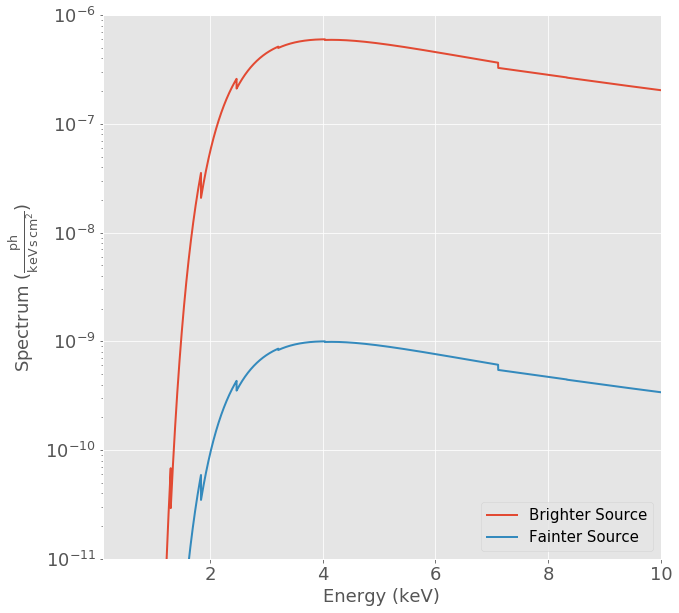

In [11]:
fig, ax = bright_spec.plot(xmin=0.1, xmax=10, ymin=1.0e-11, ymax=1.0e-6, xscale='linear', yscale='log',
                     label="Brighter Source")
faint_spec.plot(label="Fainter Source",
           fig=fig, ax=ax)
ax.legend()


### Make a spatial model that resembles the actual source

In [12]:
ra0 = 46.207 # source RA in degrees
dec0 = -0.137 # source Dec in degrees

In [13]:
# Space the point sources 2 arcsec apart on the sky. Try to mimic Bernd's image

# Let's say that the other source is \sqrt(2) arcsec west and \sqrt(2) arcsec south of the main source

offset = 1.4 / 3600. # arcsec converted to degrees
ra1 = ra0 + offset
dec1 = dec0 + offset

# Now actually create the models
pos1 = soxs.PointSourceModel(ra0, dec0)
pos2 = soxs.PointSourceModel(ra1, dec1)

We now generate energies and positions from these point source models. We want to create a large sample that we'll draw from when we run the instrument simulator, so we choose a stupidly large exposure time and a large collecting area (should be bigger than the maximum of the ARF). 

In [14]:
impossible_exposure_time = 5000.0 # ksec

In [15]:
t_exp = (impossible_exposure_time, "ks")
area = (3.0, "m**2") # make a ridiculously large 50 billion dollar fake X-ray telescope
agn1 = soxs.PhotonList.from_models("agn1", bright_spec, pos1, t_exp, area)
agn2 = soxs.PhotonList.from_models("agn2", faint_spec, pos2, t_exp, area)

soxs : [INFO     ] 2018-01-10 23:28:16,755 Creating 518424 energies from this spectrum.
soxs : [INFO     ] 2018-01-10 23:28:16,835 Finished creating energies.
soxs : [INFO     ] 2018-01-10 23:28:16,874 Creating 847 energies from this spectrum.
soxs : [INFO     ] 2018-01-10 23:28:16,876 Finished creating energies.


We can quickly show the positions using the `plot()` method of the PhotonList instances. We'll show a tiny FOV so we can be sure we got the separation right. 

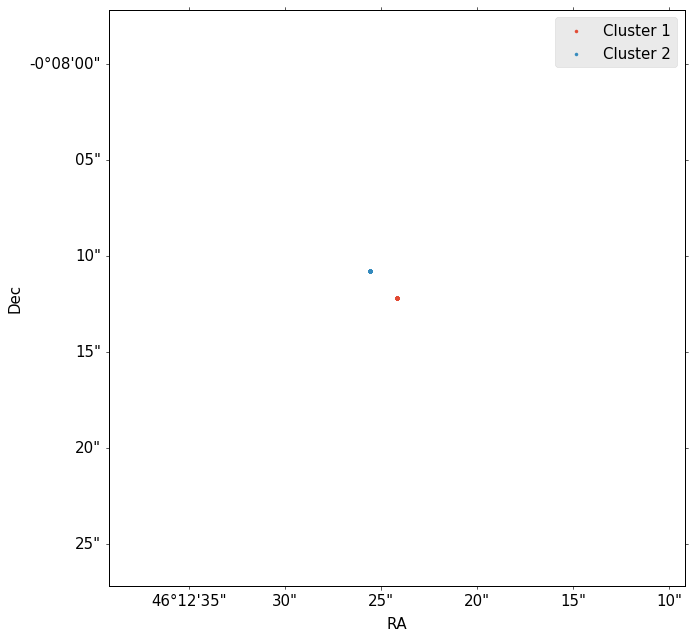

In [16]:
fig, ax = agn1.plot([46.207, -0.137], 0.5, marker='.', stride=1, label="Cluster 1")

agn2.plot([46.207, -0.137], 0.5, marker='.', stride=1, fig=fig, ax=ax, label="Cluster 2")
ax.legend()

For now I'll call this close enough. Bernd can play with this ;)

Now that we have the positions and the energies of the photons in the PhotonLists, we can write them to a SIMPUT catalog, using the SimputCatalog class. Each cluster will have its own photon list, but be part of the same SIMPUT catalog:

In [17]:
# Create the SIMPUT catalog "sim_cat" from the photon lists "cluster1" and "cluster2"
sim_cat = soxs.SimputCatalog("bernds_simulated_agn", [agn1, agn2])
# Write the catalog to a file "bernds_simulated_agn_simput.fits"
sim_cat.write_catalog(overwrite=True)

soxs : [INFO     ] 2018-01-10 23:28:21,116 Writing SIMPUT catalog file bernds_simulated_agn_simput.fits.
soxs : [INFO     ] 2018-01-10 23:28:21,120 Writing SIMPUT photon list file agn1_phlist.fits.
soxs : [INFO     ] 2018-01-10 23:28:21,225 Writing SIMPUT photon list file agn2_phlist.fits.


Finally, we can use the instrument simulator to simulate the two clusters by ingesting the SIMPUT file, setting an output file "evt.fits", setting an exposure time of 500 ks (less than the one we used to generate the source). 

We'll use *Chandra* ACIS-I as well as the *Lynx* HDXI. 

In [18]:
exposure_time = 500 # ksec

In [19]:
soxs.instrument_simulator("bernds_simulated_agn_simput.fits", "CHANDRA_evt.fits", (exposure_time, "ks"), "acisi_cy19", [46.207, -0.137], overwrite=True)

soxs : [INFO     ] 2018-01-10 23:28:21,285 Making observation of source in CHANDRA_evt.fits.
soxs : [INFO     ] 2018-01-10 23:28:21,404 Detecting events from source agn1.
soxs : [INFO     ] 2018-01-10 23:28:21,405 Applying energy-dependent effective area from acisi_aimpt_cy19.arf.
soxs : [INFO     ] 2018-01-10 23:28:21,443 351 events detected.
soxs : [INFO     ] 2018-01-10 23:28:21,447 Pixeling events.
soxs : [INFO     ] 2018-01-10 23:28:21,449 0 events were rejected because they do not fall on any CCD.
soxs : [INFO     ] 2018-01-10 23:28:21,450 Detecting events from source agn2.
soxs : [INFO     ] 2018-01-10 23:28:21,452 Applying energy-dependent effective area from acisi_aimpt_cy19.arf.
soxs : [INFO     ] 2018-01-10 23:28:21,454 0 events detected.
soxs : [WARNING  ] 2018-01-10 23:28:21,456 No events were observed for this source!!!
soxs : [INFO     ] 2018-01-10 23:28:21,457 Scattering energies with RMF acisi_aimpt_cy19.rmf.
Scattering energies : 100%|██████████| 351/351 [00:00<00:00,

In [20]:
soxs.instrument_simulator("bernds_simulated_agn_simput.fits", "LYNX_evt.fits", (exposure_time, "ks"), "hdxi", [46.207, -0.137], overwrite=True)

soxs : [INFO     ] 2018-01-10 23:28:25,202 Making observation of source in LYNX_evt.fits.
soxs : [INFO     ] 2018-01-10 23:28:25,371 Detecting events from source agn1.
soxs : [INFO     ] 2018-01-10 23:28:25,373 Applying energy-dependent effective area from xrs_hdxi_3x10.arf.
soxs : [INFO     ] 2018-01-10 23:28:25,402 3305 events detected.
soxs : [INFO     ] 2018-01-10 23:28:25,405 Pixeling events.
soxs : [INFO     ] 2018-01-10 23:28:25,410 0 events were rejected because they do not fall on any CCD.
soxs : [INFO     ] 2018-01-10 23:28:25,413 Detecting events from source agn2.
soxs : [INFO     ] 2018-01-10 23:28:25,415 Applying energy-dependent effective area from xrs_hdxi_3x10.arf.
soxs : [INFO     ] 2018-01-10 23:28:25,417 3 events detected.
soxs : [INFO     ] 2018-01-10 23:28:25,418 Pixeling events.
soxs : [INFO     ] 2018-01-10 23:28:25,419 0 events were rejected because they do not fall on any CCD.
soxs : [INFO     ] 2018-01-10 23:28:25,421 Scattering energies with RMF xrs_hdxi.rmf.

We can use the `write_image()` function in SOXS to bin the events into an image and write them to a file, restricting the energies between 0.5 and 10.0 keV (appropriate for a Chandra proposal):

In [21]:
soxs.write_image("CHANDRA_evt.fits", "CHANDRA_proposal_img.fits", emin=0.5, emax=10.0, overwrite=True)
soxs.write_image("LYNX_evt.fits", "LYNX_proposal_img.fits", emin=0.5, emax=10.0, overwrite=True)

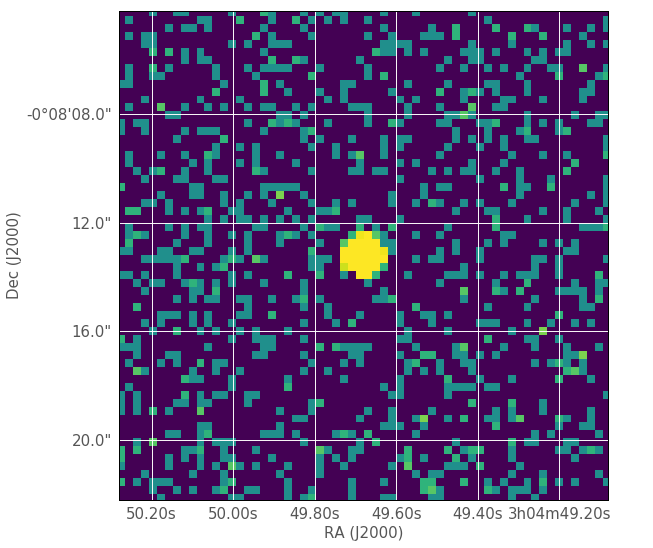

In [25]:
fig = aplpy.FITSFigure("LYNX_proposal_img.fits")
fig.show_colorscale(vmin=0.1, vmax=10.0, stretch='log', cmap="viridis")
fig.recenter(46.207, -0.137, width=0.005, height=0.005) # Centered on the source center with a width of 6 arcmin